## First Order System Simulation
A step response is a common evaluation of the dynamics of a simulated system. A linear time invariant (LTI) system can be described equivalently as a transfer function, a state space model, or solved numerically with and ODE integrator. This tutorial shows how to simulate a first and second order system in Python.

Consider a first order differential equation with constants $K_p=3$  and $\tau_p=2$, input $u$, and output response $y$.
<p class='vspace'>$$\tau_p \frac{dy}{dt} = -y + K_p u$$
</p>
<p class='vspace'>Two common methods to represent this differential equation is as a (1) semi-explicit differential equation and (2) state space model 
</p>
<div class='vspace'></div><h4>1. Differential Equation</h4>
<p>$$\frac{dy}{dt} = -\frac{1}{\tau_p} y + \frac{K_p}{\tau_p} u$$
</p>


<div class='vspace'></div><h4>2. State Space Model</h4>
<p>$$\dot x = A x + B u$$
</p>
<p class='vspace'>$$y = C x + D u$$
</p>
<p class='vspace'>$$A = -\frac{1}{\tau_p} \quad B = \frac{K_p}{\tau_p} \quad C=1 \quad D=0$$
</p>



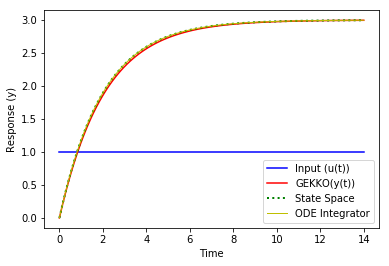

In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Simulate taup * dy/dt = -y + K*u
Kp = 3.0
taup = 2.0

# (1) State Space
A = -1.0/taup
B = Kp/taup
C = 1.0
D = 0.0
sys2 = signal.StateSpace(A,B,C,D)
t2,y2 = signal.step(sys2)

# (2) ODE Integrator
def model3(y,t):
    u = 1
    return (-y + Kp * u)/taup
t3 = np.linspace(0,14,100)
y3 = odeint(model3,0,t3)

# (3) DO IT with gekko
from gekko import GEKKO
m = GEKKO()
m.time = t3
u_step = np.zeros(100)
u_step[0:] = 1.0
u = m.Param(value=u_step)
k = 10
y4 = m.Var(value=0.0)
t4 = m.Param(value=m.time)
m.Equation(taup*y4.dt()==-y4 + Kp * u)
m.options.IMODE = 4
m.solve(disp=False)

# plot results
plt.figure(1)
plt.plot(t4,u,'b-',label='Input (u(t))')
plt.plot(t4,y4,'r-',label='GEKKO(y(t))')
plt.plot(t2,y2,'g:',linewidth=2,label='State Space')
plt.plot(t3,y3,'y-',linewidth=1,label='ODE Integrator')
plt.xlabel('Time')
plt.ylabel('Response (y)')
plt.legend(loc='best')
plt.show()

## Second Order System Simulation

<div class='vspace'></div><h5>1. Second Order Differential Equation</h5>
<p>$$\tau_s^2 \frac{d^2y}{dt^2} + 2 \zeta \tau_s \frac{dy}{dt} + y = K_p \, u$$
</p>

<div class='vspace'></div><h5>2. State Space Form</h5>
<p>$$\begin{bmatrix}\dot x_1\\\dot x_2\end{bmatrix} = \begin{bmatrix}0 && 1\\-\frac{1}{\tau_s^2} && -\frac{2 \zeta}{\tau_s}\end{bmatrix} \begin{bmatrix}x_1\\x_2\end{bmatrix} + \begin{bmatrix}0\\\frac{K_p}{\tau_{s}^2}\end{bmatrix} u$$
</p>
<p class='vspace'>$$y = \begin{bmatrix}1 && 0\end{bmatrix} \begin{bmatrix}x_1\\x_2\end{bmatrix} + \begin{bmatrix}0\end{bmatrix} u$$
</p>

<div class='vspace'></div><pre> Kp    = 2.0  # gain
 tau   = 1.0  # time constant
 zeta  = 0.25 # damping factor


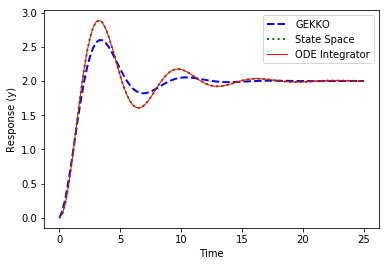

In [70]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# tau * dy2/dt2 + 2*zeta*tau*dy/dt + y = Kp*u
Kp = 2.0    # gain
tau = 1.0   # time constant
zeta = 0.25 # damping factor
theta = 0.0 # no time delay
du = 1.0    # change in u
u_step = np.zeros(100)
u_step[0:] = du
t = np.linspace(0,25,100)
# (1) State Space
A = [[0.0,1.0],[-1.0/tau**2,-2.0*zeta/tau]]
B = [[0.0],[Kp/tau**2]]
C = [1.0,0.0]
D = 0.0
sys2 = signal.StateSpace(A,B,C,D)
#t2,y2 = signal.step(sys2)
t2,y2,xsig = signal.lsim(sys2, U=u_step, T=t)

# (2) ODE Integrator
def model3(x,t):
    y = x[0]
    dydt = x[1]
    dy2dt2 = (-2.0*zeta*tau*dydt - y + Kp*du/tau**2)
    return [dydt,dy2dt2]
t3 = t
x3 = odeint(model3,[0,0],t3)
y3 = x3[:,0]

# (3) DO IT with gekko
from gekko import GEKKO
m = GEKKO()
m.time = t3
#Defining the parameters
u = m.Param(value=u_step)
t4 = m.Param(value=m.time)

m_Kp = m.Param(value=2.0)    # gain
m_tau = m.Param(value=1.0)   # time constant
m_zeta = m.Param(value=0.25) # damping factor
m_theta = m.Param(value=0.0) # no time delay
x1 = m.Var(value=0.0)
x2 = m.Var(value=0.0)
y4 = m.Var(value=0.0)
m.Equation(x1.dt() == x2)
m.Equation(x2.dt() == -x1/m_tau**2 - 2*m_zeta*x2 / m_tau + m_Kp*u/m_tau**2)
m.Equation(y4 == x1)
m.options.IMODE = 4
m.solve(disp=False)


# use A B C D matrices for state space model
#x4,y4,u = m.state_space(A,B,C,D=None) 
#m.options.IMODE = 4
#m.solve()

plt.figure(1)
plt.plot(t4,y4,'b--',linewidth=2,label='GEKKO')
plt.plot(t2,y2*du,'g:',linewidth=2,label='State Space')
plt.plot(t3,y3,'r-',linewidth=1,label='ODE Integrator')

plt.xlabel('Time')
plt.ylabel('Response (y)')
plt.legend(loc='best')
plt.savefig('2nd_order.png')
plt.show()

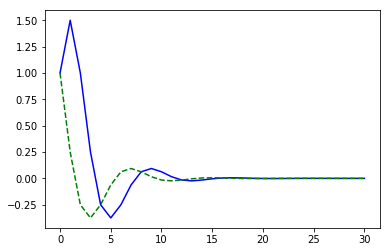

In [4]:
from pylab import *

def initialize(x0, y0):
    global x, y, xresult, yresult
    x = x0
    y = y0
    xresult = [x]
    yresult = [y]
    
def observe():
    global x, y, xresult, yresult
    xresult.append(x)
    yresult.append(y)
    
def update():
    global x, y, xresult, yresult
    x = 0.5 * x + y
    y = -0.5 * x + y
    
initialize(1,1)
for t in range(30):
    update()
    observe()
plot(xresult, 'b-')
plot(yresult, 'g--')
show()